In [1]:
from diffusers import AutoPipelineForText2Image
from transformers import pipeline
from transformers.utils import logging
import numpy as np
import random
import ray
import torch
logging.set_verbosity_info()

# Ray Data AI Pipelines Hands On

## Ray

* Open source
* Distributed scheduler supporting stateless functions ("tasks") as well as long-running stateful processes ("actors")
* Key features: 
  * Dependency tracking (task graphs)
  * Data movement and resource aware
  * Supports mix of resource requirements (e.g., GPUs), fractional, and custom resources
* Additional infra: object store, fault tolerance via GCS
* Extra libraries for AI and data processing ("Ray AI Libraries"): Data, Train, Tune, Serve, RLlib
* Easy, Python-based APIs and coding patterns

## Anyscale: Production-ready Ray from day one

* __Developer central__: multi-node backed IDE, advanced observability by Ray library
* __Optimized runtime__: faster performance and higher GPU utilization vs. OSS
* __Cluster controller__: proactive unhealthy node replacement, 0-100 node 60-sec cold starts
* __Expertise__: Training, 24/7 support, professional services

### At a high level, we'll look at using Ray Data today for...

* Scalable data ingestion
* Transforming data using Ray Data pipelines and operators
* Scalable batch inference processing with accelerators
* Joining Ray Datasets and apply data transformation to joined columns
* Integrating scalable LLM inference and fractional resource scheduling

## Batch image generation

### Scenario

We have a dataset of image prompts (in our example, animals) and another dataset with enhanced detail information for each record (in the demo, clothing the animal will wear).

Our end goal is to combine the prompts and details, then use a LLM to enhance to prompts further, employ an image gen model to create corresponding images, and produce batch output to storage.

### Ray Data motivation

It's pretty easy to write a Python script to manipulate strings and use models directly from Huggingface with code like the following:

```python
pipe = AutoPipelineForText2Image.from_pretrained("stabilityai/sdxl-turbo", torch_dtype=torch.float16, variant="fp16").to("cuda")

image = pipe("A cinematic shot of a racoon wearing an italian priest robe.", num_inference_steps=1, guidance_scale=0.0).images[0]
```

But we want to build a scalable data+AI processing pipeline. To do that, we want to ...

* leverage a scale-out cluster with multiple GPUs
* read data using as much of our cluster as is useful (parallel read)
* work with the data in chunks large enough to get benefits of scale (i.e., not suffer from excessive overhead relative to the number of records)
    * but also small enough to allow for flexible scheduling as it flows through our pipeline -- we don't want an enormous chunk to hold up processing, require excessive disk or network I/O, etc.
* assign work to, e.g., CPU nodes where GPU is not required; or to smaller, cheaper GPUs where large ones are not required
* adjust batching to optimize GPU use even when ideal batch size may be different for different operations
* handle arbitrarily large datasets by leveraging a streaming execution model
* minimize I/O costs by, e.g., fusing operations where possible
* produce predictable flow by managing backpressure (i.e., ensuring data doesn't "pile up" in between pipeline stages)
* optimize via lazy execution and flexible logical + physical planners

Ray Data is designed to address these requirements, allowing us to orchestrate at scale while still straightforward Python / Huggingface code we're used to.

### Agenda and steps for incremental implementation

1. Locate our datasets in shared storage
2. Read records using Ray Data and learn how to perform basic transformations
3. Generate images across multiple GPU nodes
4. Lab activity: generate images and store all of our prompts and outputs as parquet data
5. Join animal records against clothing outfit details to build a bigger prompt and generate enhanced images
6. Lab activity: generate and export just the images as PNG files
7. Leverage a LLM to further enhance the prompts, adding seasonal content and generate images from the full pipeline
8. Lab activity: parameterize the LLM-based component so see how Ray Data supports separation of concerns
9. Wrapup

First, we need to get all of our data in some common location where the whole cluster can see it. This might be a blob store, NFS, database, etc.

Anyscale offers `/mnt/cluster_storage` as a NFS path.

In [2]:
! head animals.csv

id,animal
100,A watercolor painting of a cat
101,A digital illustration of a dog
102,A charcoal sketch of a rabbit
103,A clay sculpture of an owl
104,An oil painting of a fox
105,A pencil drawing of a horse
106,A digital painting of a penguin
107,A watercolor of a bear
108,An ink sketch of a raccoon


In [3]:
! cp *.csv /mnt/cluster_storage/

Ray Data's `read_xxxx` methods (see I/O in Ray Docs for all the available formats and data sources) get us scalable, parallel reads.

In [4]:
animals = ray.data.read_csv('/mnt/cluster_storage/animals.csv')

animals.take_batch(3)

2025-12-05 21:49:04,669	INFO worker.py:1837 -- Connecting to existing Ray cluster at address: 10.0.147.164:6379...
2025-12-05 21:49:04,683	INFO worker.py:2014 -- Connected to Ray cluster. View the dashboard at https://session-mnqc1yx36k9vpkzivqkekde1w9.i.anyscaleuserdata.com 
2025-12-05 21:49:04,686	INFO packaging.py:380 -- Pushing file package 'gcs://_ray_pkg_aef42b58b3414a625f343c89a9e5528bdb02cff7.zip' (0.05MiB) to Ray cluster...
2025-12-05 21:49:04,688	INFO packaging.py:393 -- Successfully pushed file package 'gcs://_ray_pkg_aef42b58b3414a625f343c89a9e5528bdb02cff7.zip'.
/home/ray/anaconda3/lib/python3.12/site-packages/ray/_private/worker.py:2062: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(
2025-12-05 21:49:08,975	INFO logging.py:397 -- Registered dataset logger

Running 0: 0.00 row [00:00, ? row/s]

- ListFiles 1: 0.00 row [00:00, ? row/s]

- ReadFiles 2: 0.00 row [00:00, ? row/s]

- limit=3 3: 0.00 row [00:00, ? row/s]

2025-12-05 21:49:09,083	WARNING resource_manager.py:136 -- ⚠️  Ray's object store is configured to use only 27.0% of available memory (17.3GiB out of 64.0GiB total). For optimal Ray Data performance, we recommend setting the object store to at least 50% of available memory. You can do this by setting the 'object_store_memory' parameter when calling ray.init() or by setting the RAY_DEFAULT_OBJECT_STORE_MEMORY_PROPORTION environment variable.
2025-12-05 21:50:31,063	INFO streaming_executor.py:300 -- ✔️  Dataset dataset_1_0 execution finished in 82.03 seconds


{'id': array([100, 101, 102]),
 'animal': array(['A watercolor painting of a cat',
        'A digital illustration of a dog', 'A charcoal sketch of a rabbit'],
       dtype=object)}

Batches of records are represented as Python dicts where the keys correspond to the dataset column names and the values are a vectorized type -- usually a NumPy Array -- of values containing one value for each record in the batch.

Ray Data contains methods for basic data transformation and allow modification of dataset schema.

In [5]:
animals.rename_columns({'animal' : 'prompt'}).take_batch(3)

2025-12-05 21:50:40,063	INFO logging.py:397 -- Registered dataset logger for dataset dataset_3_0
2025-12-05 21:50:40,068	INFO streaming_executor.py:174 -- Starting execution of Dataset dataset_3_0. Full logs are in /tmp/ray/session_2025-12-05_21-42-54_386647_2345/logs/ray-data
2025-12-05 21:50:40,069	INFO streaming_executor.py:175 -- Execution plan of Dataset dataset_3_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles] -> LimitOperator[limit=3] -> TaskPoolMapOperator[Project]


Running 0: 0.00 row [00:00, ? row/s]

- ListFiles 1: 0.00 row [00:00, ? row/s]

- ReadFiles 2: 0.00 row [00:00, ? row/s]

- limit=3 3: 0.00 row [00:00, ? row/s]

- Project 4: 0.00 row [00:00, ? row/s]

2025-12-05 21:50:41,662	INFO streaming_executor.py:300 -- ✔️  Dataset dataset_3_0 execution finished in 1.59 seconds


{'id': array([100, 101, 102]),
 'prompt': array(['A watercolor painting of a cat',
        'A digital illustration of a dog', 'A charcoal sketch of a rabbit'],
       dtype=object)}

Stateful tranformation of datasets -- in this example, AI inference where the state is the image gen model -- is done with the following pattern.

1. Define a Python class (which Ray will later instantiate across the cluster as one more actor instances to do the processing)
1. Use Dataset's `map_batches` API to tell Ray to send batches of data to the `__call__` method in the actors instances
    1. `map_batches` allows us to specify resource requirements, actor pool size, batch size, and more

In [6]:
class ImageGen():
    def __init__(self):
        self.pipe = AutoPipelineForText2Image.from_pretrained("stabilityai/sdxl-turbo", torch_dtype=torch.float16, variant="fp16").to("cuda")
        
    def gen_image(self, prompts):
        return self.pipe(prompt=list(prompts), num_inference_steps=1, guidance_scale=0.0).images
    
    def __call__(self, batch):
        batch['image'] = self.gen_image(batch['prompt'])
        return batch

In [11]:
animals_images = animals.repartition(2).rename_columns({'animal' : 'prompt'}).map_batches(ImageGen, num_gpus=1, compute=ray.data.ActorPoolStrategy(size=2), batch_size=8)

Ray Datasets employ *lazy evaluation* for improved performance, so we can use APIs like `take_batch`, `take`, or `show` to trigger execution for development and testing purposes.

In [12]:
examples = animals_images.take_batch(3)

examples

2025-12-05 21:52:05,528	INFO logging.py:397 -- Registered dataset logger for dataset dataset_17_0
2025-12-05 21:52:05,530	INFO logging.py:405 -- dataset_17_0 registers for logging while another dataset dataset_10_0 is also logging. For performance reasons, we will not log to the dataset dataset_17_0 until it is the only active dataset.
2025-12-05 21:52:05,533	INFO limit_pushdown.py:140 -- Skipping push down of limit 3 through map MapBatches[MapBatches(ImageGen)] because it requires 8 rows to produce stable outputs
2025-12-05 21:52:05,542	INFO streaming_executor.py:174 -- Starting execution of Dataset dataset_17_0. Full logs are in /tmp/ray/session_2025-12-05_21-42-54_386647_2345/logs/ray-data
2025-12-05 21:52:05,542	INFO streaming_executor.py:175 -- Execution plan of Dataset dataset_17_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles] -> AllToAllOperator[Repartition] -> TaskPoolMapOperator[Project] -> ActorPoolMapOperator[MapBatches(ImageGen)

Running 0: 0.00 row [00:00, ? row/s]

- ListFiles 1: 0.00 row [00:00, ? row/s]

- ReadFiles 2: 0.00 row [00:00, ? row/s]

- Repartition 3: 0.00 row [00:00, ? row/s]

Split Repartition 4:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- Project 5: 0.00 row [00:00, ? row/s]

- MapBatches(ImageGen) 6: 0.00 row [00:00, ? row/s]

- limit=3 7: 0.00 row [00:00, ? row/s]

Loading pipeline components...:  71%|███████▏  | 5/7 [00:00<00:00,  8.12it/s] [repeated 3x across cluster]
(MapWorker(MapBatches(ImageGen)) pid=3031, ip=10.0.188.201) Failed to convert column 'image' into pyarrow array due to: Error converting data to Arrow: [<PIL.Image.Image image mode=RGB size=512x512 at 0x7C70FE06EF00>, <PIL.Image.Image image mode=RGB size=512x512 at 0x7C70FFBFB560>, <PIL.Image.Image image mode=RGB size=512x512 at 0x7C7100856390>, <PIL...; falling back to serialize as pickled python objects
(MapWorker(MapBatches(ImageGen)) pid=3031, ip=10.0.188.201) Traceback (most recent call last):
(MapWorker(MapBatches(ImageGen)) pid=3031, ip=10.0.188.201)   File "/home/ray/anaconda3/lib/python3.12/site-packages/ray/air/util/tensor_extensions/arrow.py", line 318, in _convert_to_pyarrow_native_array
(MapWorker(MapBatches(ImageGen)) pid=3031, ip=10.0.188.201)     pa_type = _infer_pyarrow_type(column_values)
(MapWorker(MapBatches(ImageGen)) pid=3031, ip=10.0.188.201)               ^

{'id': array([100, 101, 102]),
 'prompt': array(['A watercolor painting of a cat',
        'A digital illustration of a dog', 'A charcoal sketch of a rabbit'],
       dtype=object),
 'image': array([<PIL.Image.Image image mode=RGB size=512x512 at 0x7648506844A0>,
        <PIL.Image.Image image mode=RGB size=512x512 at 0x7648506D0860>,
        <PIL.Image.Image image mode=RGB size=512x512 at 0x764850687590>],
       dtype=object)}

100%|██████████| 1/1 [00:00<00:00, 11.98it/s]1, ip=10.0.188.201) 


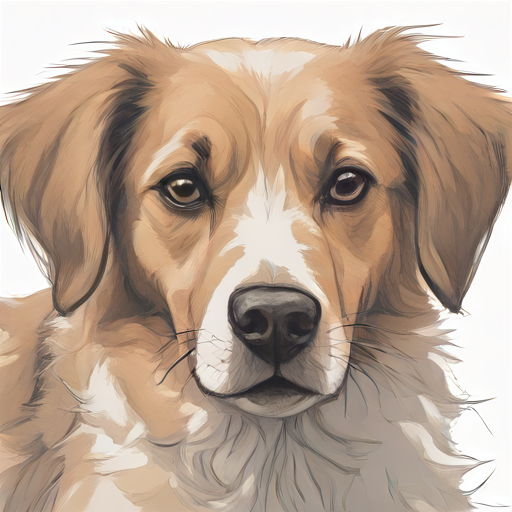

In [14]:
examples['image'][1]

## Lab: Generate and write all output to storage as parquet data

Instructions/hints:

1. Start with the Ray Dataset you'd like to write
1. Check https://docs.ray.io/en/latest/data/api/input_output.html to find a suitable write API
1. Remember to write to a *shared* file location, such as `/mnt/cluster_storage`

In [15]:
# try your code here
animals_images.write_parquet('/mnt/cluster_storage/animals_images.parquet/')


2025-12-05 21:53:55,299	INFO logging.py:397 -- Registered dataset logger for dataset dataset_19_0
2025-12-05 21:53:55,301	INFO logging.py:405 -- dataset_19_0 registers for logging while another dataset dataset_10_0 is also logging. For performance reasons, we will not log to the dataset dataset_19_0 until it is the only active dataset.
2025-12-05 21:53:55,307	INFO streaming_executor.py:174 -- Starting execution of Dataset dataset_19_0. Full logs are in /tmp/ray/session_2025-12-05_21-42-54_386647_2345/logs/ray-data
2025-12-05 21:53:55,308	INFO streaming_executor.py:175 -- Execution plan of Dataset dataset_19_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles] -> AllToAllOperator[Repartition] -> TaskPoolMapOperator[Project] -> ActorPoolMapOperator[MapBatches(ImageGen)] -> TaskPoolMapOperator[Write]


Running 0: 0.00 row [00:00, ? row/s]

- ListFiles 1: 0.00 row [00:00, ? row/s]

- ReadFiles 2: 0.00 row [00:00, ? row/s]

- Repartition 3: 0.00 row [00:00, ? row/s]

Split Repartition 4:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- Project 5: 0.00 row [00:00, ? row/s]

- MapBatches(ImageGen) 6: 0.00 row [00:00, ? row/s]

- Write 7: 0.00 row [00:00, ? row/s]

100%|██████████| 1/1 [00:00<00:00,  1.67it/s]5, ip=10.0.189.205) 
(MapWorker(MapBatches(ImageGen)) pid=3245, ip=10.0.189.205) Failed to convert column 'image' into pyarrow array due to: Error converting data to Arrow: [<PIL.Image.Image image mode=RGB size=512x512 at 0x7A5ACD5CBF20>, <PIL.Image.Image image mode=RGB size=512x512 at 0x7A5ACD5CAFC0>, <PIL.Image.Image image mode=RGB size=512x512 at 0x7A5ACD5CBDA0>, <PIL...; falling back to serialize as pickled python objects
(MapWorker(MapBatches(ImageGen)) pid=3245, ip=10.0.189.205) Traceback (most recent call last):
(MapWorker(MapBatches(ImageGen)) pid=3245, ip=10.0.189.205)   File "/home/ray/anaconda3/lib/python3.12/site-packages/ray/air/util/tensor_extensions/arrow.py", line 318, in _convert_to_pyarrow_native_array
(MapWorker(MapBatches(ImageGen)) pid=3245, ip=10.0.189.205)     pa_type = _infer_pyarrow_type(column_values)
(MapWorker(MapBatches(ImageGen)) pid=3245, ip=10.0.189.205)               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
(MapWor

## Load and join details for each prompt

Ray Data supports a number of high-performance JOIN APIs: https://docs.ray.io/en/latest/data/joining-data.html

We can use a JOIN to connect our animal records with a detailed prompt refinement unique to that record

In [16]:
! head /mnt/cluster_storage/outfits.csv

id,outfit
100,red scarf
101,blue jacket
102,green hat
103,purple cloak
104,yellow sweater
105,pink blanket
106,orange bowtie
107,teal hoodie
108,violet vest


In [17]:
outfits = ray.data.read_csv('/mnt/cluster_storage/outfits.csv')

outfits.take_batch(3)

2025-12-05 21:54:54,375	INFO logging.py:397 -- Registered dataset logger for dataset dataset_22_0
2025-12-05 21:54:54,376	INFO logging.py:405 -- dataset_22_0 registers for logging while another dataset dataset_10_0 is also logging. For performance reasons, we will not log to the dataset dataset_22_0 until it is the only active dataset.
2025-12-05 21:54:54,381	INFO streaming_executor.py:174 -- Starting execution of Dataset dataset_22_0. Full logs are in /tmp/ray/session_2025-12-05_21-42-54_386647_2345/logs/ray-data
2025-12-05 21:54:54,381	INFO streaming_executor.py:175 -- Execution plan of Dataset dataset_22_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles] -> LimitOperator[limit=3]


Running 0: 0.00 row [00:00, ? row/s]

- ListFiles 1: 0.00 row [00:00, ? row/s]

- ReadFiles 2: 0.00 row [00:00, ? row/s]

- limit=3 3: 0.00 row [00:00, ? row/s]

2025-12-05 21:54:55,978	INFO streaming_executor.py:300 -- ✔️  Dataset dataset_22_0 execution finished in 1.59 seconds


{'id': array([100, 101, 102]),
 'outfit': array(['red scarf', 'blue jacket', 'green hat'], dtype=object)}

In [18]:
animals_outfits = animals.join(outfits, 'inner', 1).repartition(8)

animals_outfits.take_batch(3)

2025-12-05 21:55:35,336	INFO logging.py:397 -- Registered dataset logger for dataset dataset_25_0
2025-12-05 21:55:35,337	INFO logging.py:405 -- dataset_25_0 registers for logging while another dataset dataset_10_0 is also logging. For performance reasons, we will not log to the dataset dataset_25_0 until it is the only active dataset.
/home/ray/anaconda3/lib/python3.12/site-packages/ray/anyscale/data/_internal/util/dependencies.py:42: UserWarning: Numba isn't available. Install numba>=0.61>=0.61 to get better performance for hash partitioning operations. Falling back to slower Python implementation for RayTurbo optimizations.
  warnings.warn(
2025-12-05 21:55:35,348	INFO streaming_executor.py:174 -- Starting execution of Dataset dataset_25_0. Full logs are in /tmp/ray/session_2025-12-05_21-42-54_386647_2345/logs/ray-data
2025-12-05 21:55:35,348	INFO streaming_executor.py:175 -- Execution plan of Dataset dataset_25_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPool

Running 0: 0.00 row [00:00, ? row/s]

- ListFiles 1: 0.00 row [00:00, ? row/s]

- ReadFiles 2: 0.00 row [00:00, ? row/s]

- ListFiles 3: 0.00 row [00:00, ? row/s]

- ReadFiles 4: 0.00 row [00:00, ? row/s]

- Join(num_partitions=1) 5: 0.00 row [00:00, ? row/s]

Shuffle 6:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Join 7:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- Repartition 8: 0.00 row [00:00, ? row/s]

Split Repartition 9:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- limit=3 10: 0.00 row [00:00, ? row/s]

2025-12-05 21:55:37,974	INFO streaming_executor.py:300 -- ✔️  Dataset dataset_25_0 execution finished in 2.62 seconds


{'id': array([100, 101, 102]),
 'animal': array(['A watercolor painting of a cat',
        'A digital illustration of a dog', 'A charcoal sketch of a rabbit'],
       dtype=object),
 'outfit': array(['red scarf', 'blue jacket', 'green hat'], dtype=object)}

We can add custom logic to combine and expand the image gen prompt using another call to `map_batches`

In this pattern, since the transformation is stateless and lightweight, we can define it as a Python function (which takes and returns a batch of records) and then use a simplified call to `map_batches` where Ray will autoscale the number of scheduled tasks in order to keep the best throughput for our pipeline.

In [19]:
def expand_prompt(batch):
    batch['prompt'] = batch['animal'] + ' wearing a ' + batch['outfit']
    return batch

In [20]:
animals_outfits.map_batches(expand_prompt).take_batch(3)

2025-12-05 21:55:44,948	INFO logging.py:397 -- Registered dataset logger for dataset dataset_27_0
2025-12-05 21:55:44,949	INFO logging.py:405 -- dataset_27_0 registers for logging while another dataset dataset_10_0 is also logging. For performance reasons, we will not log to the dataset dataset_27_0 until it is the only active dataset.
2025-12-05 21:55:44,956	INFO streaming_executor.py:174 -- Starting execution of Dataset dataset_27_0. Full logs are in /tmp/ray/session_2025-12-05_21-42-54_386647_2345/logs/ray-data
2025-12-05 21:55:44,957	INFO streaming_executor.py:175 -- Execution plan of Dataset dataset_27_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles], InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles] -> JoinOperatorWithPolars[Join(num_partitions=1)] -> AllToAllOperator[Repartition] -> LimitOperator[limit=3] -> TaskPoolMapOperator[MapBatches(expand_prompt)]


Running 0: 0.00 row [00:00, ? row/s]

- ListFiles 1: 0.00 row [00:00, ? row/s]

- ReadFiles 2: 0.00 row [00:00, ? row/s]

- ListFiles 3: 0.00 row [00:00, ? row/s]

- ReadFiles 4: 0.00 row [00:00, ? row/s]

- Join(num_partitions=1) 5: 0.00 row [00:00, ? row/s]

Shuffle 6:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Join 7:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- Repartition 8: 0.00 row [00:00, ? row/s]

Split Repartition 9:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- limit=3 10: 0.00 row [00:00, ? row/s]

- MapBatches(expand_prompt) 11: 0.00 row [00:00, ? row/s]

2025-12-05 21:55:48,005	INFO streaming_executor.py:300 -- ✔️  Dataset dataset_27_0 execution finished in 3.04 seconds


{'id': array([100, 101, 102]),
 'animal': array(['A watercolor painting of a cat',
        'A digital illustration of a dog', 'A charcoal sketch of a rabbit'],
       dtype=object),
 'outfit': array(['red scarf', 'blue jacket', 'green hat'], dtype=object),
 'prompt': array(['A watercolor painting of a cat wearing a red scarf',
        'A digital illustration of a dog wearing a blue jacket',
        'A charcoal sketch of a rabbit wearing a green hat'], dtype=object)}

We can combine the prompt expansion operation with the image gen operation to produce a new set of results

In [22]:
dressed_animals = animals_outfits.map_batches(expand_prompt).map_batches(ImageGen, batch_size=16, compute=ray.data.ActorPoolStrategy(size=2), num_gpus=1)

In [24]:
export RAY_IGNORE_UNHANDLED_ERRORS=1


SyntaxError: invalid syntax (2681081834.py, line 1)

In [25]:
examples = dressed_animals.take_batch(3)
examples

2025-12-05 21:58:25,288	INFO logging.py:397 -- Registered dataset logger for dataset dataset_33_0
2025-12-05 21:58:25,290	INFO logging.py:405 -- dataset_33_0 registers for logging while another dataset dataset_10_0 is also logging. For performance reasons, we will not log to the dataset dataset_33_0 until it is the only active dataset.
2025-12-05 21:58:25,292	INFO limit_pushdown.py:140 -- Skipping push down of limit 3 through map MapBatches[MapBatches(ImageGen)] because it requires 16 rows to produce stable outputs
2025-12-05 21:58:25,299	INFO streaming_executor.py:174 -- Starting execution of Dataset dataset_33_0. Full logs are in /tmp/ray/session_2025-12-05_21-42-54_386647_2345/logs/ray-data
2025-12-05 21:58:25,300	INFO streaming_executor.py:175 -- Execution plan of Dataset dataset_33_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles], InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles] -> JoinOperatorW

Running 0: 0.00 row [00:00, ? row/s]

- ListFiles 1: 0.00 row [00:00, ? row/s]

- ReadFiles 2: 0.00 row [00:00, ? row/s]

- ListFiles 3: 0.00 row [00:00, ? row/s]

- ReadFiles 4: 0.00 row [00:00, ? row/s]

- Join(num_partitions=1) 5: 0.00 row [00:00, ? row/s]

Shuffle 6:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Join 7:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- Repartition 8: 0.00 row [00:00, ? row/s]

Split Repartition 9:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- MapBatches(expand_prompt) 10: 0.00 row [00:00, ? row/s]

- MapBatches(ImageGen) 11: 0.00 row [00:00, ? row/s]

- limit=3 12: 0.00 row [00:00, ? row/s]

100%|██████████| 1/1 [00:00<00:00,  1.26it/s]9, ip=10.0.189.205) 
(MapWorker(MapBatches(ImageGen)) pid=5489, ip=10.0.188.201) Failed to convert column 'image' into pyarrow array due to: Error converting data to Arrow: [<PIL.Image.Image image mode=RGB size=512x512 at 0x79B034448110>, <PIL.Image.Image image mode=RGB size=512x512 at 0x79B034447230>, <PIL.Image.Image image mode=RGB size=512x512 at 0x79B0344440B0>, <PIL...; falling back to serialize as pickled python objects
(MapWorker(MapBatches(ImageGen)) pid=5489, ip=10.0.188.201) Traceback (most recent call last):
(MapWorker(MapBatches(ImageGen)) pid=5489, ip=10.0.188.201)   File "/home/ray/anaconda3/lib/python3.12/site-packages/ray/air/util/tensor_extensions/arrow.py", line 318, in _convert_to_pyarrow_native_array
(MapWorker(MapBatches(ImageGen)) pid=5489, ip=10.0.188.201)     pa_type = _infer_pyarrow_type(column_values)
(MapWorker(MapBatches(ImageGen)) pid=5489, ip=10.0.188.201)               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
(MapWor

{'id': array([100, 101, 102]),
 'animal': array(['A watercolor painting of a cat',
        'A digital illustration of a dog', 'A charcoal sketch of a rabbit'],
       dtype=object),
 'outfit': array(['red scarf', 'blue jacket', 'green hat'], dtype=object),
 'prompt': array(['A watercolor painting of a cat wearing a red scarf',
        'A digital illustration of a dog wearing a blue jacket',
        'A charcoal sketch of a rabbit wearing a green hat'], dtype=object),
 'image': array([<PIL.Image.Image image mode=RGB size=512x512 at 0x764850683A70>,
        <PIL.Image.Image image mode=RGB size=512x512 at 0x764828F617C0>,
        <PIL.Image.Image image mode=RGB size=512x512 at 0x764828F601D0>],
       dtype=object)}

100%|██████████| 1/1 [00:00<00:00,  3.89it/s]9, ip=10.0.189.205) 
2025-12-05 21:58:42,097	ERROR worker.py:433 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::MapWorker(MapBatches(ImageGen)).submit() (pid=4519, ip=10.0.189.205, actor_id=9315cc10edc2e7f0e7f1fcee03000000, repr=MapWorker(MapBatches(ImageGen)))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ray/anaconda3/lib/python3.12/site-packages/ray/data/_internal/execution/util.py", line 80, in __call__
    return future.result()
           ^^^^^^^^^^^^^^^
  File "/home/ray/anaconda3/lib/python3.12/concurrent/futures/_base.py", line 456, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/home/ray/anaconda3/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/home/ray/anaconda3/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^

In [26]:
examples

{'id': array([100, 101, 102]),
 'animal': array(['A watercolor painting of a cat',
        'A digital illustration of a dog', 'A charcoal sketch of a rabbit'],
       dtype=object),
 'outfit': array(['red scarf', 'blue jacket', 'green hat'], dtype=object),
 'prompt': array(['A watercolor painting of a cat wearing a red scarf',
        'A digital illustration of a dog wearing a blue jacket',
        'A charcoal sketch of a rabbit wearing a green hat'], dtype=object),
 'image': array([<PIL.Image.Image image mode=RGB size=512x512 at 0x764850683A70>,
        <PIL.Image.Image image mode=RGB size=512x512 at 0x764828F617C0>,
        <PIL.Image.Image image mode=RGB size=512x512 at 0x764828F601D0>],
       dtype=object)}

In [27]:
examples['prompt'][0]

'A watercolor painting of a cat wearing a red scarf'

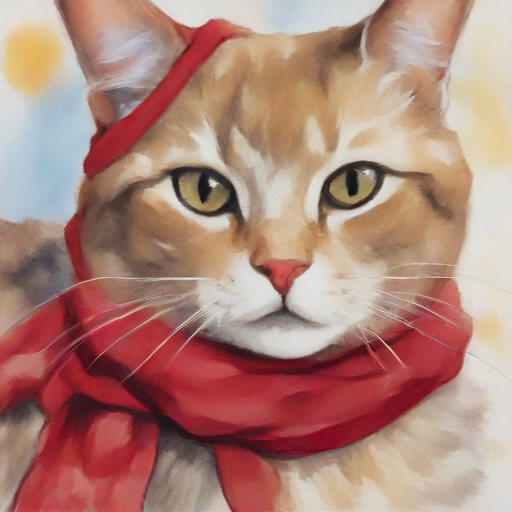

In [28]:
examples['image'][0]

## Lab: generate images for the input prompts and write the images to a folder

> Hint 1: Use `dataset.write_images(...)`
>
> Hint 2: To use `dataset.write_images(...)`, the images will need to be NumPy arrays (instead of PIL Image objects). You can use `np.array(my_pil_image)` to do that conversion. Use that API along with `map_batches` to convert all of your images prior to calling `write_images`

In [29]:
# try your code here
def image_to_array(batch):
    batch['image'] = [np.array(i) for i in batch['image']]
    return batch
    
animals_images.map_batches(image_to_array).write_images('/mnt/cluster_storage/animals_images/', 'image')

2025-12-05 22:00:06,648	INFO logging.py:397 -- Registered dataset logger for dataset dataset_36_0
2025-12-05 22:00:06,649	INFO logging.py:405 -- dataset_36_0 registers for logging while another dataset dataset_10_0 is also logging. For performance reasons, we will not log to the dataset dataset_36_0 until it is the only active dataset.
2025-12-05 22:00:06,653	INFO streaming_executor.py:174 -- Starting execution of Dataset dataset_36_0. Full logs are in /tmp/ray/session_2025-12-05_21-42-54_386647_2345/logs/ray-data
2025-12-05 22:00:06,654	INFO streaming_executor.py:175 -- Execution plan of Dataset dataset_36_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles] -> AllToAllOperator[Repartition] -> TaskPoolMapOperator[Project] -> ActorPoolMapOperator[MapBatches(ImageGen)] -> TaskPoolMapOperator[MapBatches(image_to_array)->Write]


Running 0: 0.00 row [00:00, ? row/s]

- ListFiles 1: 0.00 row [00:00, ? row/s]

- ReadFiles 2: 0.00 row [00:00, ? row/s]

- Repartition 3: 0.00 row [00:00, ? row/s]

Split Repartition 4:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- Project 5: 0.00 row [00:00, ? row/s]

- MapBatches(ImageGen) 6: 0.00 row [00:00, ? row/s]

- MapBatches(image_to_array)->Write 7: 0.00 row [00:00, ? row/s]

100%|██████████| 1/1 [00:00<00:00,  1.76it/s]3, ip=10.0.189.205) 
(MapWorker(MapBatches(ImageGen)) pid=4813, ip=10.0.189.205) Failed to convert column 'image' into pyarrow array due to: Error converting data to Arrow: [<PIL.Image.Image image mode=RGB size=512x512 at 0x715FBF242240>, <PIL.Image.Image image mode=RGB size=512x512 at 0x715FAFF3B320>, <PIL.Image.Image image mode=RGB size=512x512 at 0x715FAFF3B410>, <PIL...; falling back to serialize as pickled python objects
(MapWorker(MapBatches(ImageGen)) pid=4813, ip=10.0.189.205) Traceback (most recent call last):
(MapWorker(MapBatches(ImageGen)) pid=4813, ip=10.0.189.205)   File "/home/ray/anaconda3/lib/python3.12/site-packages/ray/air/util/tensor_extensions/arrow.py", line 318, in _convert_to_pyarrow_native_array
(MapWorker(MapBatches(ImageGen)) pid=4813, ip=10.0.189.205)     pa_type = _infer_pyarrow_type(column_values)
(MapWorker(MapBatches(ImageGen)) pid=4813, ip=10.0.189.205)               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
(MapWor

## Enhance pipeline with LLM-generation of prompts

We can leverage a LLM to create more varied and detailed image prompts -- as well as add dynamism like a seasonal element -- by adding a LLM batch inference step to the pipeline.

To implement this operation, we'll
1. Create a Python class to encasulate the logic and data transformtion
1. Use `map_batches` to route batches of data from our Ray Dataset through this transformation operation
1. Demonstrate Ray's support for fractional resource allocation, so that we can schedule 4 GPU-dependent operator instances with only 2 GPUs
1. Demonstrate the decoupling of operator batch sizes from each other (as well as from Dataset block size) to optimally use our models and GPUs

In [30]:
class Enhancer():
    def __init__(self):
        self.pipe = pipeline("text-generation", model="Qwen/Qwen2.5-0.5B-Instruct", device='cuda')
        
    def chat(self, prompts):
        messages = []
        for p in prompts:
            season = random.choice(['winter', 'spring', 'summer', 'fall'])
                                   
            message = [{"role": "system", "content": "You are a helpful assistant." +
                        "Enhance the image description with two short elements corresponding to the " + season + 
                        "season. Keep animal wearing clothing and retain image medium information (like photo or painting). Return new description only, no intro."},
                        {"role": "user", "content": p }]
            messages.append(message)
        return [out[0]['generated_text'][-1]['content'] for out in self.pipe(messages, max_new_tokens=200, batch_size=2)]
    
    def __call__(self, batch):
        batch['prompt'] = self.chat(batch['prompt'])
        return batch

In [31]:
seasonal_images = animals_outfits.map_batches(expand_prompt) \
                    .map_batches(Enhancer, batch_size=4, concurrency=2, num_gpus=0.6) \
                    .map_batches(ImageGen, batch_size=8, concurrency=2, num_gpus=0.4)

2025-12-05 22:00:43,299	WARNING util.py:598 -- The argument ``concurrency`` is deprecated in Ray 2.51. Please specify argument ``compute`` instead. For more information, see https://docs.ray.io/en/master/data/transforming-data.html#stateful-transforms.
2025-12-05 22:00:43,302	WARNING util.py:598 -- The argument ``concurrency`` is deprecated in Ray 2.51. Please specify argument ``compute`` instead. For more information, see https://docs.ray.io/en/master/data/transforming-data.html#stateful-transforms.


In [32]:
examples = seasonal_images.take_batch(5)

2025-12-05 22:00:43,347	INFO logging.py:397 -- Registered dataset logger for dataset dataset_41_0
2025-12-05 22:00:43,349	INFO logging.py:405 -- dataset_41_0 registers for logging while another dataset dataset_10_0 is also logging. For performance reasons, we will not log to the dataset dataset_41_0 until it is the only active dataset.
2025-12-05 22:00:43,351	INFO limit_pushdown.py:140 -- Skipping push down of limit 5 through map MapBatches[MapBatches(ImageGen)] because it requires 8 rows to produce stable outputs
2025-12-05 22:00:43,359	INFO streaming_executor.py:174 -- Starting execution of Dataset dataset_41_0. Full logs are in /tmp/ray/session_2025-12-05_21-42-54_386647_2345/logs/ray-data
2025-12-05 22:00:43,359	INFO streaming_executor.py:175 -- Execution plan of Dataset dataset_41_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles], InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles] -> JoinOperatorWi

Running 0: 0.00 row [00:00, ? row/s]

- ListFiles 1: 0.00 row [00:00, ? row/s]

- ReadFiles 2: 0.00 row [00:00, ? row/s]

- ListFiles 3: 0.00 row [00:00, ? row/s]

- ReadFiles 4: 0.00 row [00:00, ? row/s]

- Join(num_partitions=1) 5: 0.00 row [00:00, ? row/s]

Shuffle 6:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Join 7:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- Repartition 8: 0.00 row [00:00, ? row/s]

Split Repartition 9:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- MapBatches(expand_prompt) 10: 0.00 row [00:00, ? row/s]

- MapBatches(Enhancer) 11: 0.00 row [00:00, ? row/s]

- MapBatches(ImageGen) 12: 0.00 row [00:00, ? row/s]

- limit=5 13: 0.00 row [00:00, ? row/s]

Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  4.67it/s]
(MapWorker(MapBatches(Enhancer)) pid=5018, ip=10.0.189.205) Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.
(MapWorker(MapBatches(Enhancer)) pid=5018, ip=10.0.189.205) Device set to use cuda
Loading pipeline components...:  86%|████████▌ | 6/7 [00:01<00:00,  3.05it/s] [repeated 4x across cluster]
(MapWorker(MapBatches(Enhancer)) pid=5018, ip=10.0.189.205) A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  4.00it/s]
(MapWorker(MapBatches(Enhancer)) pid=5884, ip=10.0.188.201) Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.
(MapWorker(MapBatches(Enhancer)) pid=5884, ip=10.0.188.201) Device set to use cuda
(Map

In [33]:
examples['prompt'][0]

'A striking printmaking piece depicting a sea otter in a plump, winter-themed sweater, set against a vibrant autumnal background featuring trees laden with colorful leaves and a serene beach scene. The ocean waves ripple gently as they approach, hinting at a peaceful, seaside environment during this season.'

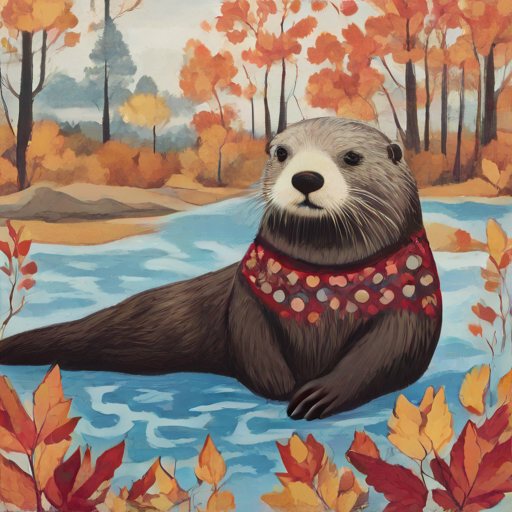

(MapWorker(MapBatches(Enhancer)) pid=5884, ip=10.0.188.201) A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
(MapWorker(MapBatches(Enhancer)) pid=5018, ip=10.0.189.205) A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer. [repeated 5x across cluster]
(MapWorker(MapBatches(Enhancer)) pid=5884, ip=10.0.188.201) A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer. [repeated 3x across cluster]
(MapWorker(MapBatches(Enhancer)) pid=5884, ip=10.0.188.201) A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer. [repeated 

In [34]:
examples['image'][0]

## Lab: Modify the `Enhancer` class and `seasonal_images` pipeline for parametrization

* Use variables contaioning the model name and the name of the dataset column containing the prompt as below

In [35]:
enhancer_model = "Qwen/Qwen2.5-0.5B-Instruct"

prompt_column = "prompt"

In [36]:
# try your code here: updated Enhancer class
class Enhancer():
    def __init__(self, model_name, prompt_column_name):
        self.pipe = pipeline("text-generation", model=model_name, device='cuda')
        self.prompt_column_name = prompt_column_name
        
    def chat(self, prompts):
        messages = []
        for p in prompts:
            season = random.choice(['winter', 'spring', 'summer', 'fall'])
                                   
            message = [{"role": "system", "content": "You are a helpful assistant." +
                        "Enhance the image description with two short elements corresponding to the " + season + 
                        "season. Keep animal wearing clothing and retain image medium information (like photo or painting). Return new description only, no intro."},
                        {"role": "user", "content": p }]
            messages.append(message)
        return [out[0]['generated_text'][-1]['content'] for out in self.pipe(messages, max_new_tokens=200, batch_size=2)]
    
    def __call__(self, batch):
        batch[self.prompt_column_name] = self.chat(batch[self.prompt_column_name])
        return batch


In [38]:
# try your code here: updated pipelineto generate seasonal_images Ray dataset
seasonal_images = animals_outfits.map_batches(expand_prompt) \
                    .map_batches(Enhancer, batch_size=4, compute=ray.data.ActorPoolStrategy(size=2), num_gpus=0.6, fn_constructor_args=[enhancer_model, prompt_column]) \
                    .map_batches(ImageGen, batch_size=8, compute=ray.data.ActorPoolStrategy(size=2), num_gpus=0.4)

In [39]:
examples = seasonal_images.take_batch(4)
examples['prompt'][0]

2025-12-05 22:03:59,437	INFO logging.py:397 -- Registered dataset logger for dataset dataset_48_0
2025-12-05 22:03:59,439	INFO logging.py:405 -- dataset_48_0 registers for logging while another dataset dataset_10_0 is also logging. For performance reasons, we will not log to the dataset dataset_48_0 until it is the only active dataset.
2025-12-05 22:03:59,441	INFO limit_pushdown.py:140 -- Skipping push down of limit 4 through map MapBatches[MapBatches(ImageGen)] because it requires 8 rows to produce stable outputs
2025-12-05 22:03:59,448	INFO streaming_executor.py:174 -- Starting execution of Dataset dataset_48_0. Full logs are in /tmp/ray/session_2025-12-05_21-42-54_386647_2345/logs/ray-data
2025-12-05 22:03:59,449	INFO streaming_executor.py:175 -- Execution plan of Dataset dataset_48_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles], InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles] -> JoinOperatorWi

Running 0: 0.00 row [00:00, ? row/s]

- ListFiles 1: 0.00 row [00:00, ? row/s]

- ReadFiles 2: 0.00 row [00:00, ? row/s]

- ListFiles 3: 0.00 row [00:00, ? row/s]

- ReadFiles 4: 0.00 row [00:00, ? row/s]

- Join(num_partitions=1) 5: 0.00 row [00:00, ? row/s]

Shuffle 6:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Join 7:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- Repartition 8: 0.00 row [00:00, ? row/s]

Split Repartition 9:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- MapBatches(expand_prompt) 10: 0.00 row [00:00, ? row/s]

- MapBatches(Enhancer) 11: 0.00 row [00:00, ? row/s]

- MapBatches(ImageGen) 12: 0.00 row [00:00, ? row/s]

- limit=4 13: 0.00 row [00:00, ? row/s]

(MapWorker(MapBatches(Enhancer)) pid=5506, ip=10.0.189.205) Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.
Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00,  8.45it/s]
(MapWorker(MapBatches(Enhancer)) pid=5506, ip=10.0.189.205) Device set to use cuda
(MapWorker(MapBatches(Enhancer)) pid=5506, ip=10.0.189.205) A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00,  7.41it/s]
(MapWorker(MapBatches(Enhancer)) pid=6409, ip=10.0.188.201) Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.
Loading pipeline components...:  71%|███████▏  | 5/7 [00:00<00:00, 17.53it/s] [repeated 2x across cluster]
(MapWorker(MapBatches(Enhancer)) pid=6409, ip=10.0.188.201) Device set to use cuda
(Map

"A serene watercolor painting of a cat perched on a lush green lawn, its fur glistening under the warm summer sun, adorned with a vibrant red scarf that adds a touch of warmth and color to the scene, capturing the essence of summer's vibrant colors and fresh air."

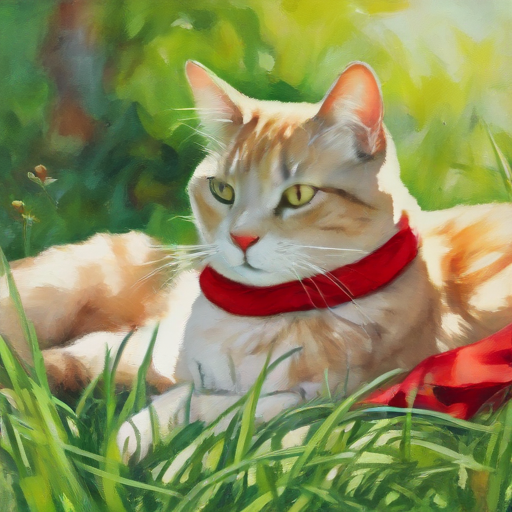

(MapWorker(MapBatches(Enhancer)) pid=6409, ip=10.0.188.201) A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
(MapWorker(MapBatches(Enhancer)) pid=6409, ip=10.0.188.201) A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer. [repeated 4x across cluster]
(MapWorker(MapBatches(Enhancer)) pid=6409, ip=10.0.188.201) A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer. [repeated 3x across cluster]
(MapWorker(MapBatches(Enhancer)) pid=5506, ip=10.0.189.205) A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer. [repeated 

(autoscaler +48m5s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.


In [40]:
examples['image'][0]

## Wrapup

* Q&A
* Next Steps